In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
import sympy as sy
np.set_printoptions(precision=4)
from functools import partial
from tqdm import tqdm

In [2]:
#%matplotlib inline
def pltAttr(x='', y='', title=None, legend=None, save=None):
    plt.tight_layout()
    if legend is not None:
        plt.legend(loc=legend)
    plt.xlabel(x)
    plt.ylabel(y)
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)

These are the equations for the ODE

In [3]:
# define state equations
def ode(y,t, lambda_):
    x = y[0]
    v = y[1]
    p1 = y[2]
    p2 = y[3]
    
    #calculate various things
    fp_x = fp_lam(x)
    normp_x = normp_lam(x)
    fp_normp_x = fp_normp_lam(x)
    u = np.clip(p2*max_u**2 / (2*(1-lambda_)), min_u, max_u)

    #find vdot and pdot
    xdot = v / np.sqrt(1 + fp_x**2)
    vdot = u - g*fp_x / np.sqrt(1 + fp_x**2)
    pd1 = -p1*v*normp_x + p2*g*fp_normp_x
    pd2 = -p1/np.sqrt(1+fp_x**2)
    
    return np.array([xdot, vdot, pd1, pd2])

This is the function we want to find 0's of.  
We put in initial conditions for p1 and p2, and get out final condition on x and v  
We want to find which initial conditions for p1 and p2 gives out 0s for x and v  

In [97]:
def func(p, tf=5, lambda_=1/2):
    return odeint(ode, np.array([x0, v0, p[0], p[1]]), np.linspace(t0, tf,20), (lambda_,), atol=1e-10)[-1,0:2]

This is the algorithm for finding our roots. It requires a initial derivative and guess as a first estimate.

In [382]:
def find_zero(f, p0, Df, alpha, maxI, tf=None, display=True):
    if display:
        loop = tqdm(total=maxI, position=0, leave=True)
    
    f_p1 = np.inf
    i = 0
    while np.linalg.norm(f_p1) > 10**-3 and i < maxI:
        #compute solution
        f_p0 = f(p0)

        #update guess
        p1 = p0 - alpha*(np.linalg.inv(Df)@f_p0)
        
        #update derivative
        f_p1 = f(p1)
        s = p1-p0
        y = f_p1 - f_p0
        Df = Df + np.outer(y-Df@s, s) / s@s
        
        #update values
#         print(p0)
        if display:
            loop.set_description(f'tf: {np.round(tf,4)}, x0,v0: {f_p1}, p0: {p1}')
            loop.update(1)
        p0 = p1
        i = i+1
        
    if i == maxI:
        return None
    if display:
        loop.close()
    return p1

This function computes all costs across a range of ending times T. It does it by:  
  1. Using first value of T
    1. Find actual p0 using shooting method and using given guess p0
    2. Use that initial p0 to solve for control
    3. Saves cost/control
  2. For rest of values in T (as far as the shooting method allows, it'll fail once a control isn't posisble), do steps A-C using previous found p0 as guess
  3. Return all costs and p0s

In [643]:
def find_costs(p0, T, func, lambda_, display=True):
    p0s = np.zeros((len(T)+2,2))
    p0s[0] = p0
    p0s[1] = p0
    cost = np.zeros_like(T)

    for i, tf in enumerate(T):
        func_tf = partial(func, tf=tf, lambda_=lambda_)

        #use finite difference to estimate derivative
        p0 = 2*p0s[i+1] - p0s[i]
        Df = np.zeros((2,2))
        h = 1e-4
        #d/dp1
        Df[:,0] = (func_tf(p0 + np.array([h,0])) - func_tf(p0 - np.array([h,0]))) / (2*h)
        #d/dp2
        Df[:,1] = (func_tf(p0 + np.array([0,h])) - func_tf(p0 - np.array([0,h]))) / (2*h)
        Df *= 10

        #find zero
        p0 = find_zero(func_tf, p0, Df, 0.9, 1500, tf, display)
        #stop if it didn't converge
        if p0 is None:
            break
        else:
            p0s[i+2] = p0

            #solve for control and save cost
            t = np.linspace(t0, tf, 100)
            sol = odeint(ode, np.array([x0, v0, p0[0], p0[1]]), t, (lambda_,), atol=1e-10)[:,3]
            u = np.clip(sol*max_u**2 / (2*(1-lambda_)), min_u, max_u)
            cost[i] = tf*lambda_ + (1-lambda_)*np.trapz((u/5)**2, t)
        
    print("Done")
    
    return cost, p0s[2:]

Now we define everything we need (and can tweak as necessary and solve!)

In [424]:
#surface
x = sy.symbols('x') 
f = -sy.cos(x)

fp = sy.simplify( sy.diff(f) )
norm = sy.simplify( 1 / sy.sqrt(1+fp**2) )
normp = sy.simplify( sy.diff(norm) )
fp_norm = sy.simplify( fp*norm )
fp_normp = sy.simplify( sy.diff(fp_norm) )

f_lam = sy.lambdify(x, f)
fp_lam = sy.lambdify(x, fp)
normp_lam = sy.lambdify(x, normp)
fp_normp_lam = sy.lambdify(x, fp_normp)

In [425]:
#inital conditions and time
t0 = 0
x0 = -4*np.pi
v0 = 0

# global variables
g = 9.81
min_u = -5
max_u = 5

In [426]:
def func(p, tf=5, lambda_=1/2):
    return odeint(ode, np.array([x0, v0, p[0], p[1]]), np.linspace(t0, tf, 20), (lambda_,), atol=1e-10)[-1,0:2]

In [526]:
grid = np.linspace(-2,2,25)
test = np.array([[func(np.array([p0, p1]), tf=8, lambda_=0.5) for p0 in grid] for p1 in grid])

tf: 10.0, x0,v0: [-0.1268 -2.156 ], p0: [ 1.2366 -0.1627]:  12%|█▏        | 122/1000 [25:10<3:01:10, 12.38s/it]
tf: 10.0, x0,v0: [-0.1069  0.2197], p0: [ 1.3212 -0.4244]:   4%|▍         | 41/1000 [24:35<9:35:00, 35.98s/it]
tf: 10.0, x0,v0: [6.7412 0.4719], p0: [ 1.2632 -0.1309]:  36%|███▋      | 365/1000 [23:51<41:30,  3.92s/it]
tf: 8.0, x0,v0: [-56.1245 -22.9473], p0: [ 0.6438 -0.0052]:   5%|▌         | 50/1000 [04:05<1:17:49,  4.92s/it]
tf: 8.0, x0,v0: [ 0.1048 -1.135 ], p0: [ 0.5739 -0.1615]:  94%|█████████▍| 944/1000 [07:34<00:26,  2.08it/s]
tf: 10.0, x0,v0: [-3.5916 -4.1918], p0: [ 1.2167 -0.184 ]:   6%|▋         | 65/1000 [33:58<8:08:42, 31.36s/it]


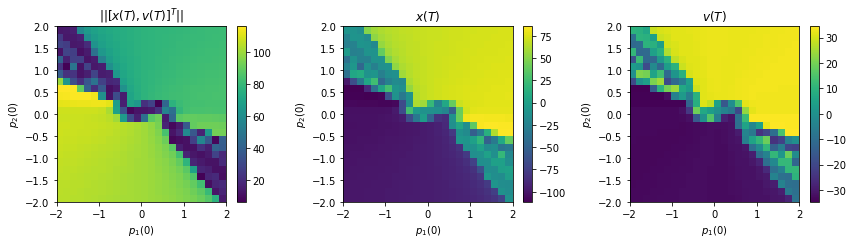

In [527]:
X,Y = np.meshgrid(grid, grid)
fig, ax = plt.subplots(1,3, figsize=(12,3.5))

im1 = ax[0].pcolormesh(X,Y, np.linalg.norm(test, axis=2))
ax[0].set_title("$|| [x(T), v(T)]^T ||$")
fig.colorbar(im1, ax=ax[0])

im2 = ax[1].pcolormesh(X,Y, test[:,:,0])
ax[1].set_title("$x(T)$")
fig.colorbar(im2, ax=ax[1])

im3 = ax[2].pcolormesh(X,Y, test[:,:,1])
ax[2].set_title("$v(T)$")
fig.colorbar(im3, ax=ax[2])

for i in range(3):
    ax[i].set_xlabel('$p_1(0)$')
    ax[i].set_ylabel('$p_2(0)$')
    
plt.tight_layout()
plt.savefig("search_initial_flat.pdf", bbox_inches="tight")
plt.show()

In [528]:
np.linalg.norm(test, axis=2).min()

3.9198881498940827

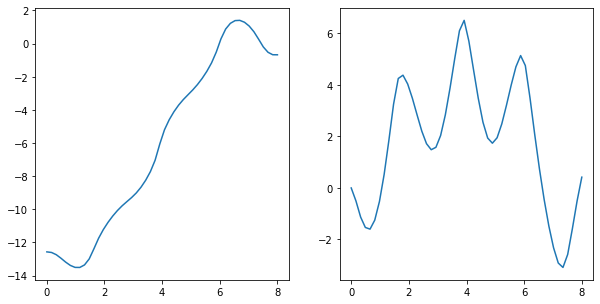

[-0.6795  0.4188]
[-0.6795  0.4188  0.3865 -0.0106]


In [536]:
p0 = np.array([ 1.2355, -0.1631]) * (1 - 0.5)# good for lambda = 0
t = np.linspace(t0, 8, 50)
sol = odeint(ode, np.array([x0, v0, p0[0], p0[1]]), t, (0.5,), atol=1e-10)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(t, sol[:,0])
plt.subplot(122)
plt.plot(t, sol[:,1])
plt.show()
print(func(p0, tf=8, lambda_=0.5))
print(sol[-1])

In [641]:
#intial guesses
p01 = np.array([ 1.2111, -0.1924]) # good for lambda = 0, 0.25
p02 = np.array([ 1.2355, -0.162]) # good for lambda = 0.5
p03 = np.array([ 0.3122, -0.0365])/(1-.75) # good for lambda = 0.75
# p0 = np.array([ 1.2355, -0.162]) # good for lambda = 0.9
# p0 = np.array([ 0.1274, -0.0114])/(1-.9) # good for lambda = 0.9
guesses = [p01, p01, p02, p03]
print(p0*(1-.9))

T = np.geomspace(5.5, 8, 150)[::-1]

[ 0.1274 -0.0114]


In [644]:
#solve 
lambdas = [0, 0.25, 0.5, 0.75] # values in [0, 1)
costs = []
p0ss = []
for p0, lambda_ in zip(guesses, lambdas):
    print(f"Starting lambda={lambda_}", end=' ')
    cost, p0s = find_costs(p0 * (1-lambda_), T, func, lambda_, display=True)
    costs.append(cost)
    p0ss.append(p0s)

Starting lambda=0 

tf: 8.0, x0,v0: [-0.0005 -0.0007], p0: [ 1.2319 -0.1668]:   4%|▎         | 55/1500 [00:10<04:33,  5.28it/s]        
tf: 7.9799, x0,v0: [ 0.0003 -0.0007], p0: [ 1.2488 -0.1459]:  13%|█▎        | 195/1500 [00:35<03:56,  5.51it/s]        
tf: 7.9599, x0,v0: [ 0.0002 -0.0008], p0: [ 1.2475 -0.1476]:  54%|█████▍    | 817/1500 [02:29<02:04,  5.48it/s]        
tf: 7.9399, x0,v0: [-0.0002 -0.0008], p0: [ 1.2461 -0.1493]:   1%|          | 18/1500 [00:03<04:32,  5.44it/s]
tf: 7.9199, x0,v0: [-0.0006 -0.0007], p0: [ 1.2447 -0.151 ]:   1%|▏         | 21/1500 [00:03<04:39,  5.30it/s]
tf: 7.9, x0,v0: [-0.0005 -0.0005], p0: [ 1.2433 -0.1527]:   1%|▏         | 22/1500 [00:04<04:30,  5.46it/s]
tf: 7.8802, x0,v0: [-0.0005 -0.0005], p0: [ 1.2419 -0.1545]:   2%|▏         | 23/1500 [00:04<04:33,  5.40it/s]
tf: 7.8604, x0,v0: [-0.0004 -0.0005], p0: [ 1.2405 -0.1562]:   1%|▏         | 21/1500 [00:04<04:44,  5.21it/s]
tf: 7.8407, x0,v0: [-0.0006 -0.0007], p0: [ 1.2391 -0.1579]:   1%|▏         | 21/1500 [00:03

Done
Starting lambda=0.25 

tf: 8.0, x0,v0: [0.0009 0.0004], p0: [ 0.924 -0.125]:  11%|█▏        | 169/1500 [00:31<04:09,  5.34it/s]          
tf: 7.9799, x0,v0: [-0.0001 -0.0009], p0: [ 0.9366 -0.1094]:  14%|█▍        | 210/1500 [00:37<03:52,  5.55it/s]        
tf: 7.9599, x0,v0: [ 0.0002 -0.001 ], p0: [ 0.9356 -0.1107]:  59%|█████▊    | 881/1500 [02:38<01:51,  5.56it/s]        
tf: 7.9399, x0,v0: [ 7.5374e-05 -7.3972e-04], p0: [ 0.9346 -0.112 ]:   1%|▏         | 19/1500 [00:03<04:31,  5.46it/s]
tf: 7.9199, x0,v0: [-0.0005 -0.0008], p0: [ 0.9336 -0.1133]:   1%|          | 18/1500 [00:03<04:31,  5.45it/s]
tf: 7.9, x0,v0: [-0.0006 -0.0007], p0: [ 0.9325 -0.1145]:   1%|▏         | 21/1500 [00:03<04:34,  5.38it/s]
tf: 7.8802, x0,v0: [-0.0006 -0.0007], p0: [ 0.9315 -0.1158]:   1%|▏         | 21/1500 [00:03<04:34,  5.39it/s]
tf: 7.8604, x0,v0: [-0.0002 -0.0004], p0: [ 0.9304 -0.1171]:   1%|▏         | 19/1500 [00:03<04:43,  5.22it/s]
tf: 7.8407, x0,v0: [-0.0005 -0.0006], p0: [ 0.9293 -0.1185]:   1%|▏         | 21/1500

Done
Starting lambda=0.5 

tf: 8.0, x0,v0: [0.0002 0.0009], p0: [ 0.616  -0.0833]:  26%|██▋       | 395/1500 [01:15<03:31,  5.24it/s]          
tf: 7.9799, x0,v0: [-0.0003  0.0009], p0: [ 0.6244 -0.073 ]:   7%|▋         | 110/1500 [00:20<04:14,  5.46it/s]      
tf: 7.9599, x0,v0: [ 0.0008 -0.0004], p0: [ 0.6237 -0.0738]:  57%|█████▋    | 859/1500 [02:34<01:55,  5.57it/s]        
tf: 7.9399, x0,v0: [0.0007 0.0006], p0: [ 0.623  -0.0747]:   2%|▏         | 32/1500 [00:05<04:29,  5.46it/s] 
tf: 7.9199, x0,v0: [-0.0007 -0.0005], p0: [ 0.6224 -0.0755]:   2%|▏         | 25/1500 [00:04<04:25,  5.56it/s]
tf: 7.9, x0,v0: [-0.0004 -0.0005], p0: [ 0.6217 -0.0764]:   1%|▏         | 21/1500 [00:03<04:31,  5.44it/s]
tf: 7.8802, x0,v0: [-0.0005 -0.0008], p0: [ 0.621  -0.0772]:   1%|          | 16/1500 [00:02<04:36,  5.37it/s]
tf: 7.8604, x0,v0: [-0.0004 -0.0007], p0: [ 0.6203 -0.0781]:   1%|          | 17/1500 [00:03<04:40,  5.28it/s]
tf: 7.8407, x0,v0: [-0.0005 -0.0008], p0: [ 0.6196 -0.079 ]:   1%|          | 13/1500 [00:02<0

Done
Starting lambda=0.75 

tf: 8.0, x0,v0: [-0.0009  0.0004], p0: [ 0.3125 -0.0361]:  14%|█▍        | 215/1500 [00:37<03:46,  5.68it/s]        
tf: 7.9799, x0,v0: [ 8.8405e-04 -1.6160e-05], p0: [ 0.3122 -0.0365]:  21%|██        | 318/1500 [00:57<03:32,  5.57it/s]
tf: 7.9599, x0,v0: [ 0.0008 -0.0005], p0: [ 0.3119 -0.0369]:   4%|▍         | 67/1500 [00:12<04:19,  5.52it/s]        
tf: 7.9399, x0,v0: [ 0.0009 -0.0005], p0: [ 0.3115 -0.0373]:   2%|▏         | 31/1500 [00:05<04:25,  5.53it/s]        
tf: 7.9199, x0,v0: [ 0.0004 -0.0009], p0: [ 0.3112 -0.0377]:   1%|          | 13/1500 [00:02<04:26,  5.57it/s]
tf: 7.9, x0,v0: [ 0.0003 -0.0008], p0: [ 0.3108 -0.0382]:   1%|          | 18/1500 [00:03<04:22,  5.65it/s]        
tf: 7.8802, x0,v0: [-6.3934e-06 -9.1465e-04], p0: [ 0.3105 -0.0386]:   1%|          | 14/1500 [00:02<04:31,  5.47it/s]
tf: 7.8604, x0,v0: [-0.0002 -0.0008], p0: [ 0.3101 -0.039 ]:   1%|          | 15/1500 [00:02<04:35,  5.39it/s]
tf: 7.8407, x0,v0: [-0.0004 -0.0009], p0: [ 0.3098 -0.0395]:   1%|  

Done


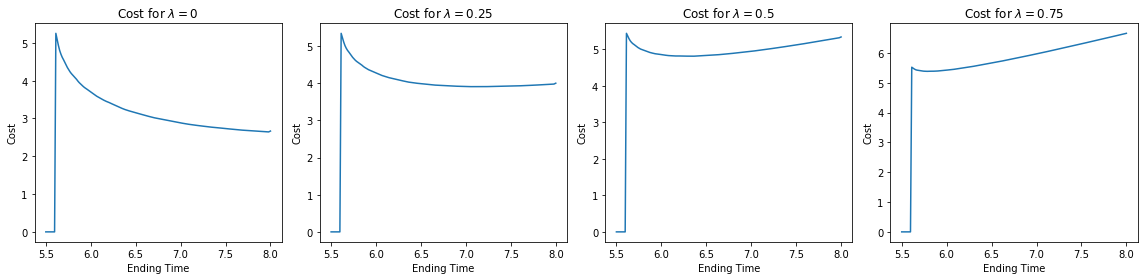

In [647]:
plt.figure(figsize=(4*len(lambdas),4))
for i, lambda_ in enumerate(lambdas):
    plt.subplot(1,len(lambdas),i+1)
    plt.plot(T, costs[i])
    pltAttr("Ending Time", "Cost", rf"Cost for $\lambda = {lambda_}$")
    
plt.savefig("cost_change_cos.pdf", bbox_inches="tight")

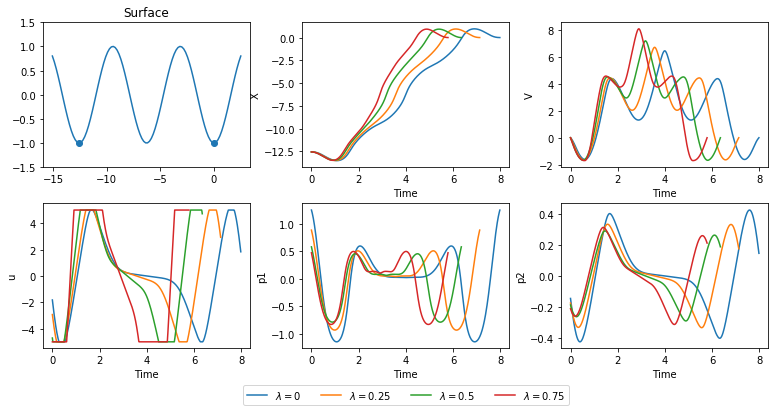

In [651]:
#find index of best cost
min_idx = [np.where(cost==np.min(cost[np.nonzero(cost)]))[0][0] for cost in costs]

fig, ax = plt.subplots(2, 3, figsize=(13,6))
for i, (idx, lambda_) in enumerate(zip(min_idx, lambdas)):

    p0 = p0ss[i][idx]
    t = np.linspace(t0, T[idx], 500)

    sol = odeint(ode, np.array([x0, v0, p0[0], p0[1]]), t, (lambda_,), atol=1e-10)
    ax[0,1].plot(t, sol[:,0])
    ax[0,2].plot(t, sol[:,1])
    ax[1,1].plot(t, sol[:,2], label=rf"$\lambda={lambda_}$")
    ax[1,2].plot(t, sol[:,3])

    ones = np.ones_like(sol[:,3])
    ax[1,0].plot(t, np.minimum(np.maximum(ones*min_u, sol[:,3]*25 / (2*(1-lambda_))), ones*max_u))

ax[1,1].legend(loc='center', ncol=len(lambdas), bbox_to_anchor= (0.5, -0.32))
ax[0,1].set_ylabel('X')
ax[0,2].set_ylabel('V')
ax[1,0].set_ylabel('u') 
ax[1,1].set_ylabel('p1')    
ax[1,2].set_ylabel('p2')    
for i in ax.flatten()[1:]:
    i.set_xlabel("Time")

x = np.linspace(x0-5/2,0+5/2,100)
ax[0,0].plot(x, f_lam(x))
temp = np.array([x0, 0])
ax[0,0].scatter(temp, f_lam(temp))
ax[0,0].set_title("Surface")
ax[0,0].set_ylim([-1.5, 1.5])

# plt.tight_layout()
fig.subplots_adjust(wspace=0.25, hspace=0.25)
plt.savefig("solution_cos.pdf", bbox_inches="tight")
plt.show()